In [1]:
# imports

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import itertools
from pathlib import Path
import torch
import json

from utils import (
    extract_diagonals,
    fold_OP_mat,
    matrix_processing,
    plot_complex_matrix,
    get_interpolated_matrix,
    Siren,
    check_D4_symmetries,
    apply_periodic_boundary_conditions,
    get_normalized_coords,
    run_model_inference,
    print_comparison,
    reformat_matrix_from_diagonals,
    unfold_OP_mat
)
import utils

In [2]:
plt.style.use(["science", "notebook", "grid"])

### Load Data and run Hyperparameter Optimization script

In [3]:
# state variables
U = 3
error_c='2e-5'
label = f"U_{U}_ground_state"

In [4]:
with h5py.File(
    f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}/{label}.h5",
    "r",
) as f:
    OP_8x8 = f["OP_8x8"][()]
    print(OP_8x8.shape)
    OP_10x10 = f["OP_10x10"][()]
    print(OP_10x10.shape)
    OP_18x18 = f["OP_18x18"][()]
    print(OP_18x18.shape)

(128, 128)
(200, 200)
(648, 648)


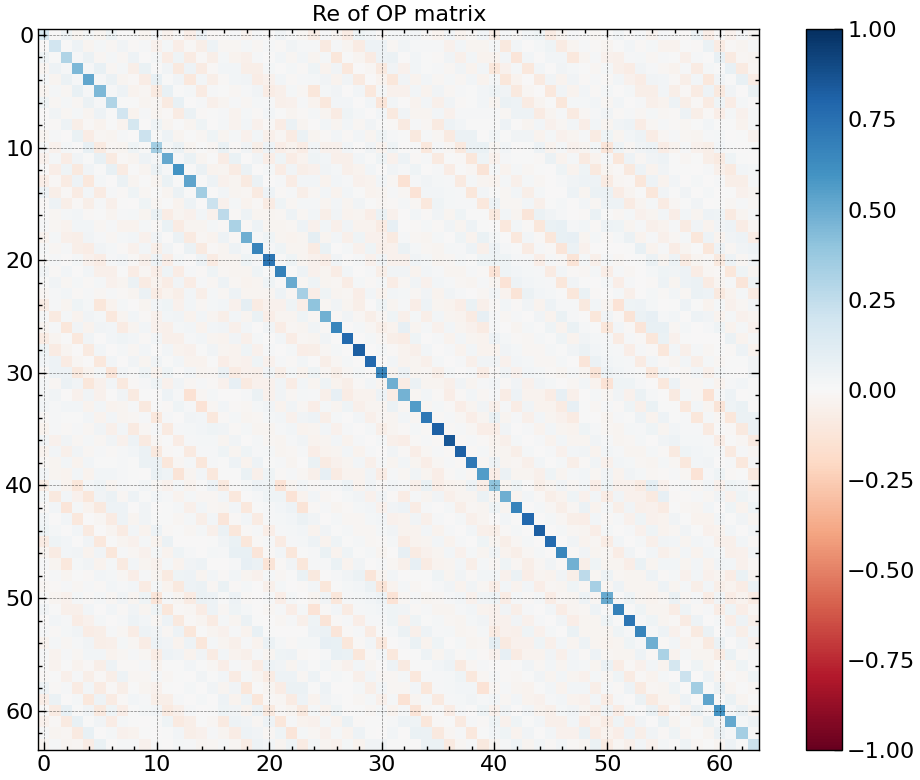

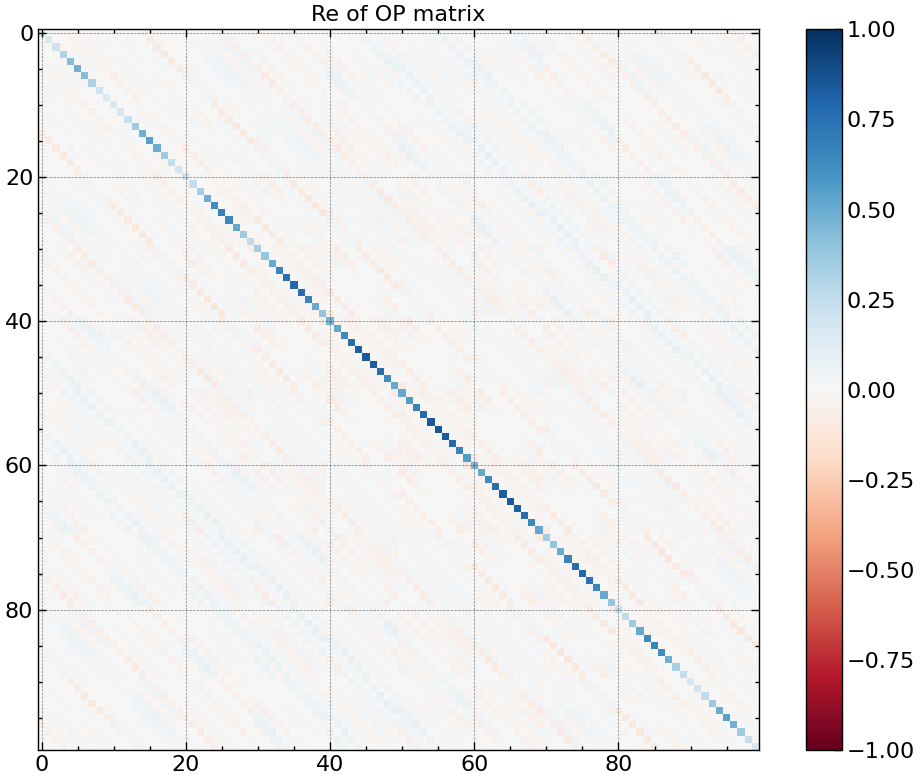

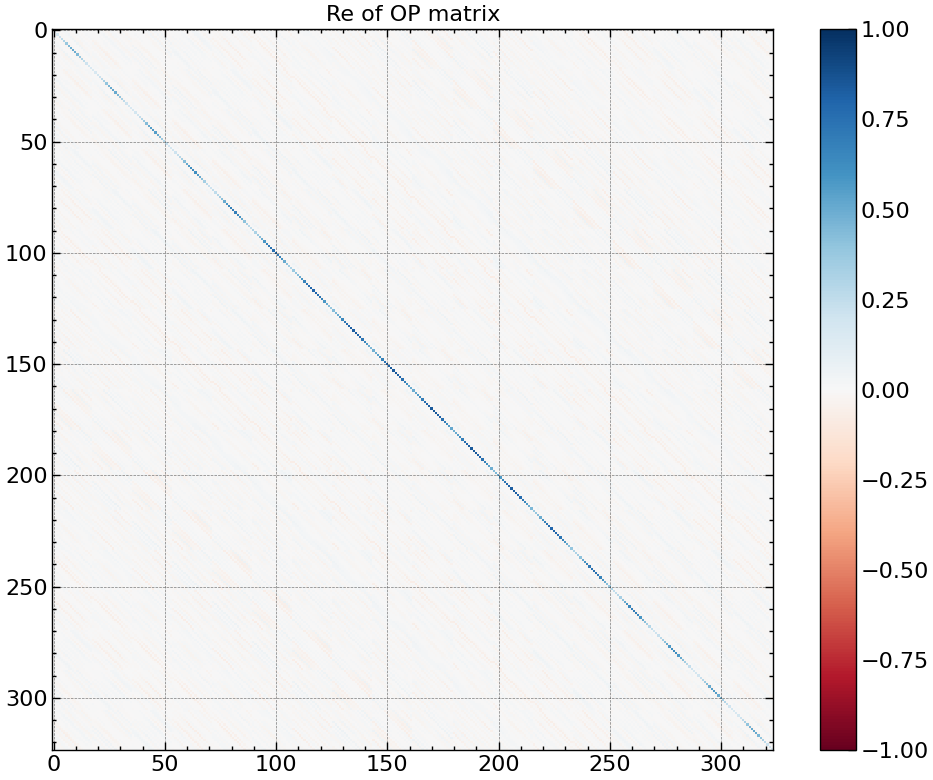

In [5]:
plot_complex_matrix(fold_OP_mat(OP_8x8)[:, :, 0, 0])
plot_complex_matrix(fold_OP_mat(OP_10x10)[:, :, 0, 0])
plot_complex_matrix(fold_OP_mat(OP_18x18)[:, :, 0, 0])

In [6]:
np.max(np.abs(get_interpolated_matrix(OP_18x18, 8) - OP_8x8))

np.float64(0.14673879787964858)

In [7]:
testing_mode = False  # change this to False when running "for real"

# first make sure they have the same pattern
assert np.max(np.abs(get_interpolated_matrix(OP_8x8, 18) - OP_18x18)) < 0.5, (
    "Sorry, patterns do not match"
)

for diag_idx, alpha_1, alpha_2 in itertools.product((0, 1), repeat=3):
    diagonal_matrix_8x8 = extract_diagonals(fold_OP_mat(OP_8x8))[diag_idx][
        :, :, alpha_1, alpha_2
    ]
    diagonal_matrix_18x18 = extract_diagonals(fold_OP_mat(OP_18x18))[diag_idx][
        :, :, alpha_1, alpha_2
    ]

    # check to make sure it has significantly nonzero entries
    if np.max(np.abs(diagonal_matrix_18x18)) < 0.1:
        print(
            f"Elt ({alpha_1 + 1}, {alpha_2 + 1}) of Diagonal {diag_idx + 1} skipped: No significantly nonzero entries."
        )
        continue

    # otherwise, make a new folder with the appropriate name
    print(
        f"\nStarting training for ({alpha_1 + 1}, {alpha_2 + 1}) element of Diagonal {diag_idx + 1}..."
    )
    dir_name = f"diag_{diag_idx + 1}_matrix_{alpha_1 + 1}{alpha_2 + 1}"
    path = Path(dir_name)
    path.mkdir(
        exist_ok=testing_mode
    )  # can throw an error if the folder already exists, depends on testing_mode

    # call the function
    matrix_processing(
        OP_8x8=diagonal_matrix_8x8,
        OP_18x18=diagonal_matrix_18x18,
        foldername=str(path.resolve()),
        repeat_trials=20,
        n_startup_trials=48,
        gpus_per_trial=0.1,
        total_steps=100,
        num_samples=200,
    )
    print(
        f"\nFinished training for ({alpha_1 + 1}, {alpha_2 + 1}) element of Diagonal {diag_idx + 1}!"
    )
print("\nDone!")

2025-10-27 11:32:15,448	ERROR tune_controller.py:1331 -- Trial task failed for trial training_script_d3f089ac
Traceback (most recent call last):
  File "/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/ray/_private/worker.py", line 2882, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
 


Ray Tune finished.


RuntimeError: No best trial found for the given metric: max_diff. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

### Inference/Evaluation

In [7]:
def get_model_output(L: int, diag_idx, alpha_1, alpha_2):
    foldername = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/SIREN_{label}/diag_{diag_idx+1}_matrix_{alpha_1+1}{alpha_2+1}"
    new_model = torch.load(f"{foldername}/model_IP.pth", weights_only=False, map_location=torch.device('cpu'))

    with open(f"{foldername}/normalization_constants.json", "r") as f:
        stats = json.load(f)
        mean = stats["mean"]
        std_dev = stats["std_dev"]

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cpu")    # torch.device("cuda" if torch.cuda.is_available() else "cpu")
    new_model.to(device)

    with h5py.File(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}/{label}.h5",
        "r",
    ) as f:
        OP_8x8 = f["OP_8x8"][()]
        print(OP_8x8.shape)
        OP_18x18 = f["OP_18x18"][()]
        print(OP_18x18.shape)
    
    # first make sure they have the same pattern
    assert np.max(np.abs(get_interpolated_matrix(OP_8x8, 18) - OP_18x18)) < 0.5, (
        "Sorry, patterns do not match"
    )

    diagonal_matrix_8x8 = extract_diagonals(fold_OP_mat(OP_8x8))[diag_idx][:, :, alpha_1, alpha_2]
    # diagonal_matrix_18x18 = extract_diagonals(fold_OP_mat(OP_18x18))[diag_idx][:, :, alpha_1, alpha_2]


    # determine which type of B.C.'s to apply
    clipped_OP_8x8 = diagonal_matrix_8x8[1:, 1:]
    if (check_D4_symmetries(clipped_OP_8x8)["reflection_anti_diag"] is True):
        mode = "adjacent"
    else:
        mode = "opposite"
    print(f"Selected mode: {mode}")

    # preprocess the diagonal matrices
    diag_matrix_8x8_np = apply_periodic_boundary_conditions(diagonal_matrix_8x8, mode=mode).numpy()
    # diag_matrix_18x18_np = apply_periodic_boundary_conditions(diagonal_matrix_18x18, mode=mode).numpy()

    # get symmetries
    symmetries = check_D4_symmetries(diag_matrix_8x8_np)

    # get model outputs and symmetrize
    X_coords = torch.from_numpy(get_normalized_coords(L)).float().to(device)
    output_large = run_model_inference(
        new_model,
        X_coords,
        mean=mean,
        std_dev=std_dev,
        symmetries=symmetries,
    )
    # print_comparison(diag_matrix_18x18_np, output_18x18)

    return output_large[:L, :L]

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


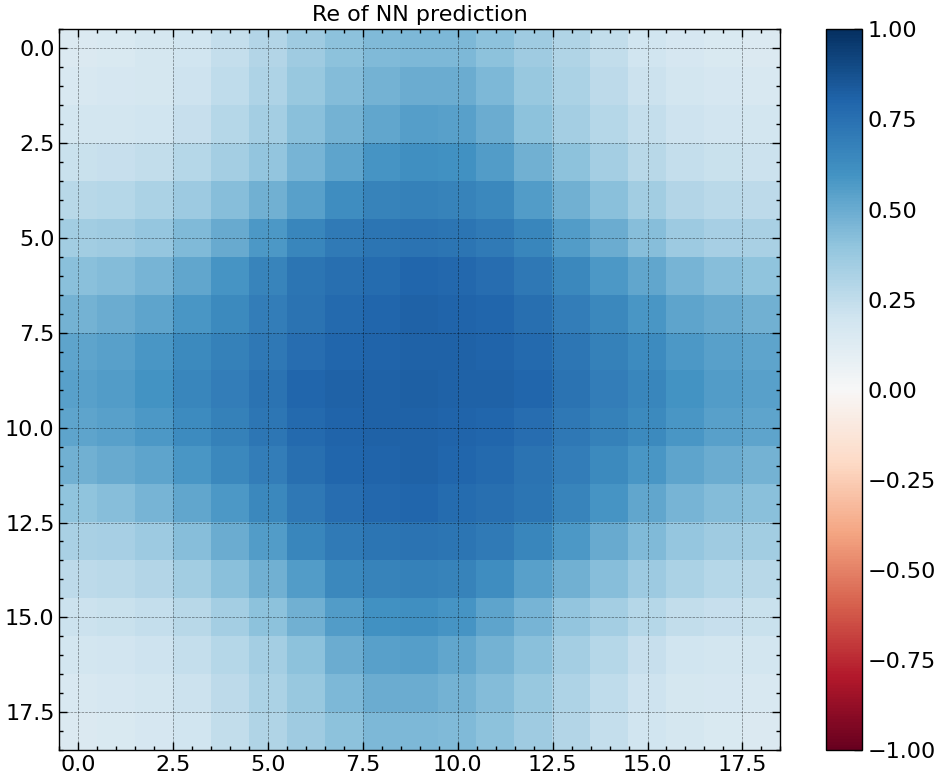

(18, 18)


In [9]:
test = get_model_output(L=18, diag_idx=0, alpha_1=1, alpha_2=1)
print(test.shape)

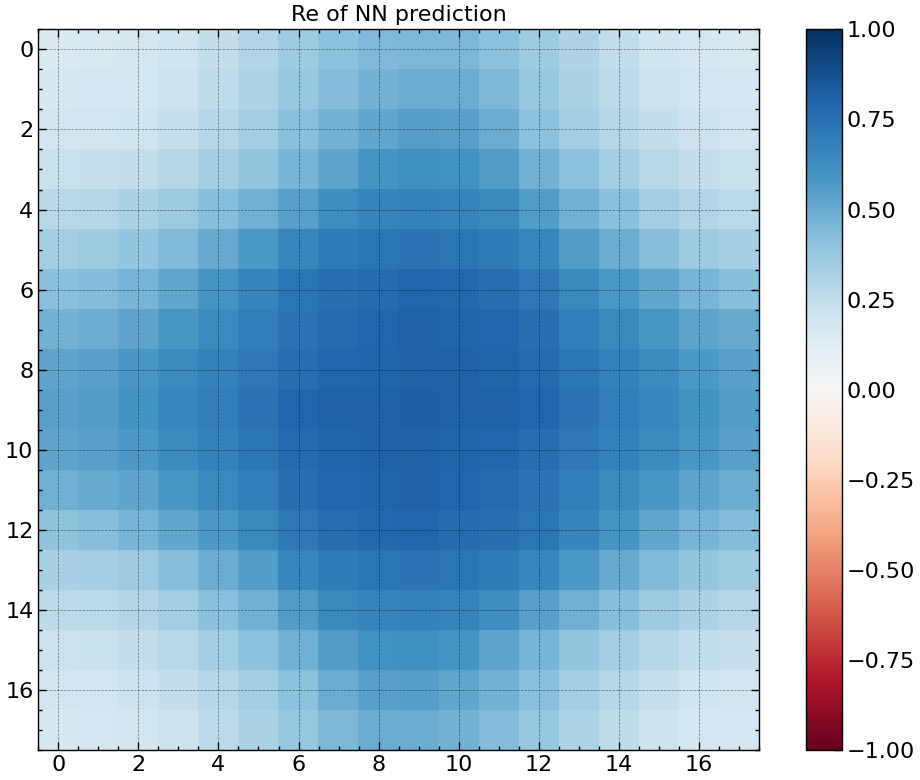

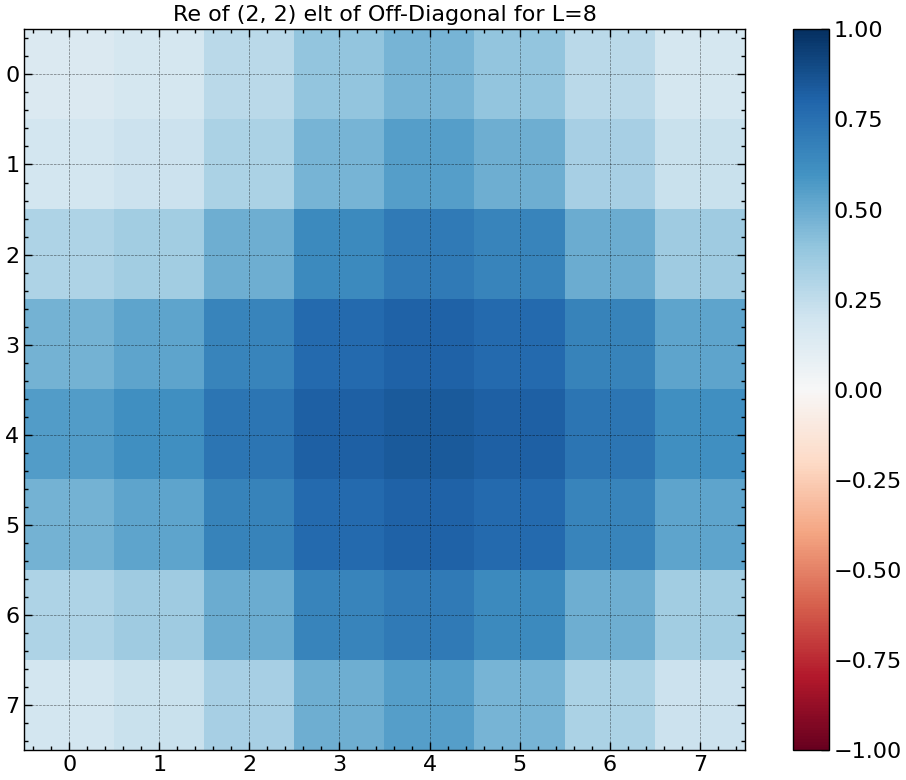

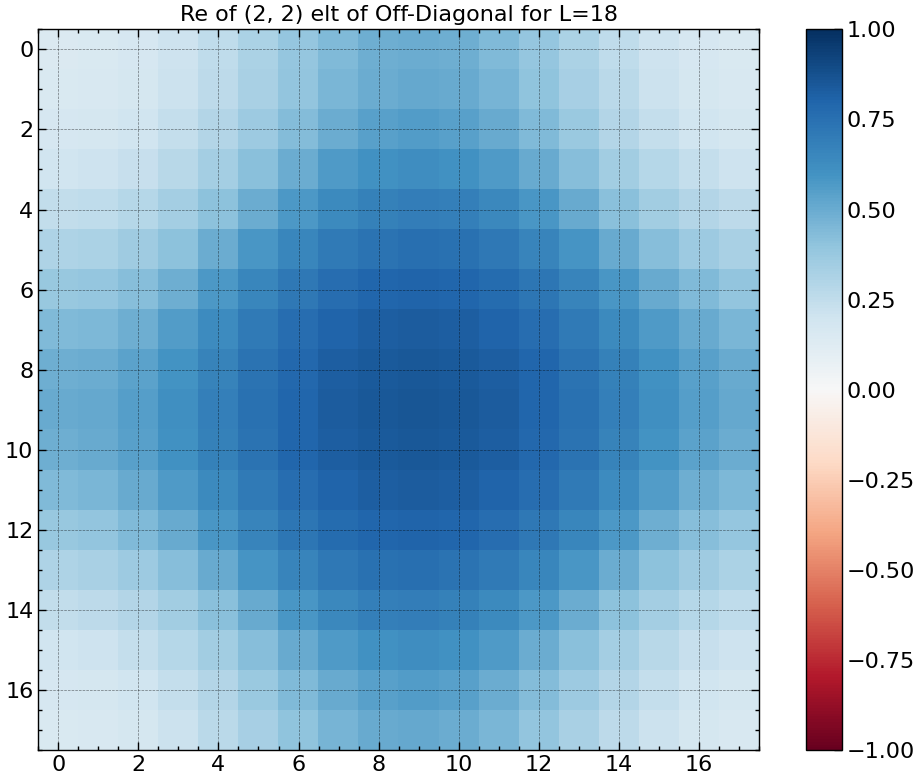

In [10]:
plot_complex_matrix(test, title="NN prediction")
plot_complex_matrix(extract_diagonals(fold_OP_mat(OP_8x8))[0][:, :, 1, 1], title="(2, 2) elt of Off-Diagonal for L=8")
plot_complex_matrix(extract_diagonals(fold_OP_mat(OP_18x18))[0][:, :, 1, 1], title="(2, 2) elt of Off-Diagonal for L=18")

In [11]:
def make_HF_ML(L: int):
    diag_list = []
    for diag_idx in (0, 1):
        diag_tensor = np.zeros((L, L, 2, 2))
        for alpha in (0, 1):
            try:
                diag_tensor[:, :, alpha, alpha] = get_model_output(L, diag_idx, alpha, alpha)
            except:
                diag_tensor[:, :, alpha, alpha] = 0
                continue
        diag_list.append(diag_tensor)
    folded_OP_mat = reformat_matrix_from_diagonals(diag_list)
    print(f"Folded OP_mat shape: {folded_OP_mat.shape}")

    # more postprocessing
    test_OP = unfold_OP_mat(folded_OP_mat)
    # transpose to get it back in Julia format
    OP_results = np.transpose(test_OP)
    # separate into real and imaginary parts
    OP_results = np.array([OP_results.real, OP_results.imag])
    print(f"OP_results shape: {OP_results.shape}")

    # now save to file
    with h5py.File(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/SIREN_{label}/SIREN_{L}x{L}_{label}.h5", "w"
    ) as f:
        f.create_dataset("ML_1", data=OP_results)

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


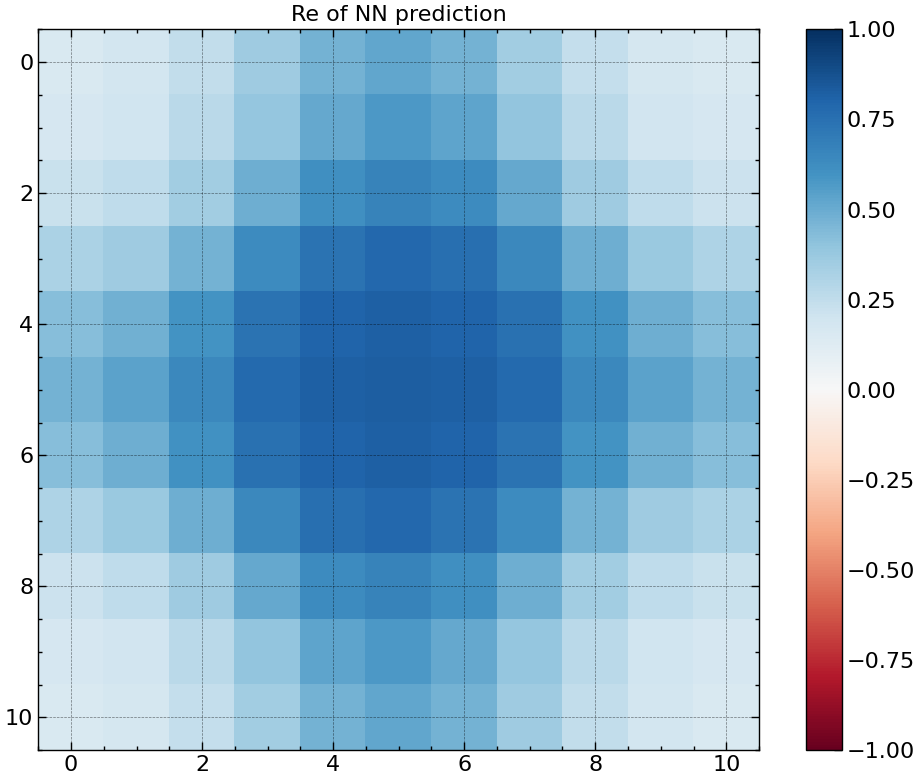

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


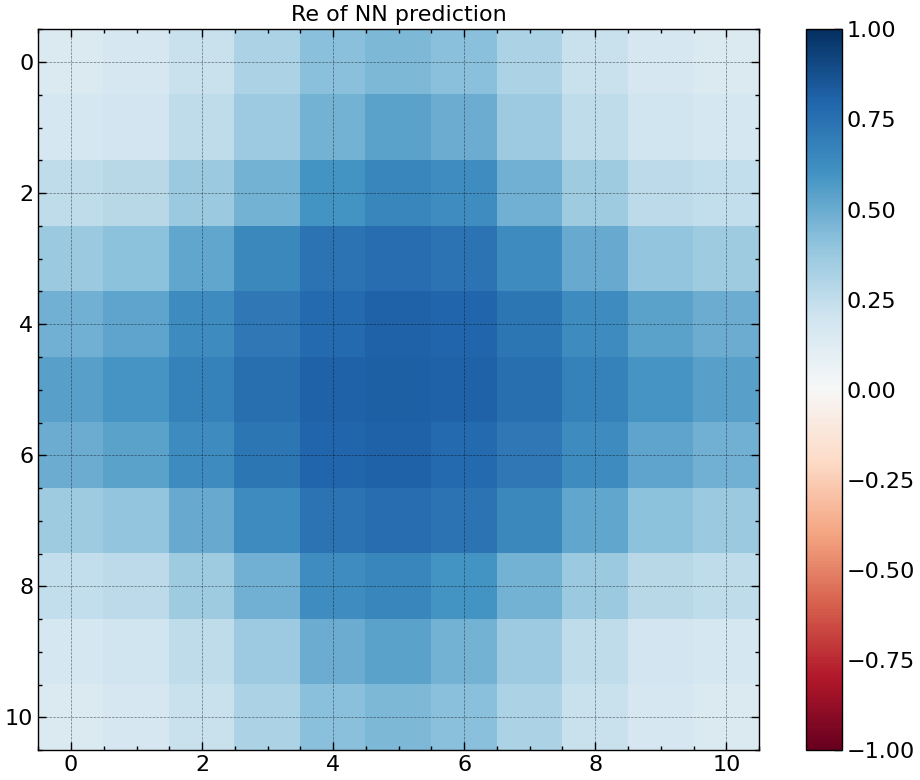

Folded OP_mat shape: (100, 100, 2, 2)
OP_results shape: (2, 200, 200)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


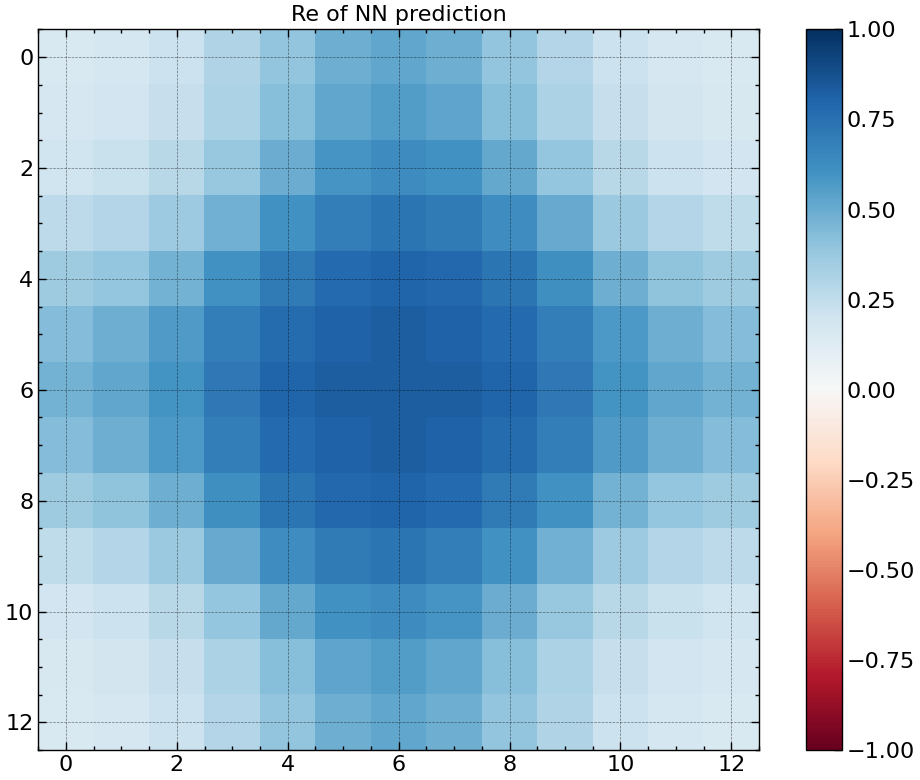

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


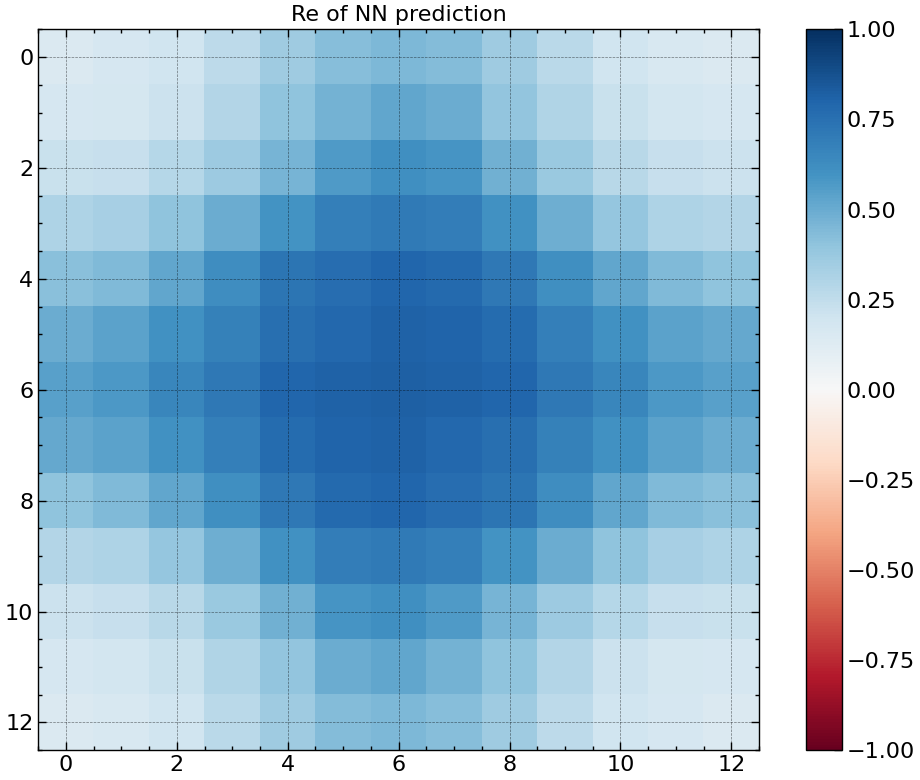

Folded OP_mat shape: (144, 144, 2, 2)
OP_results shape: (2, 288, 288)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


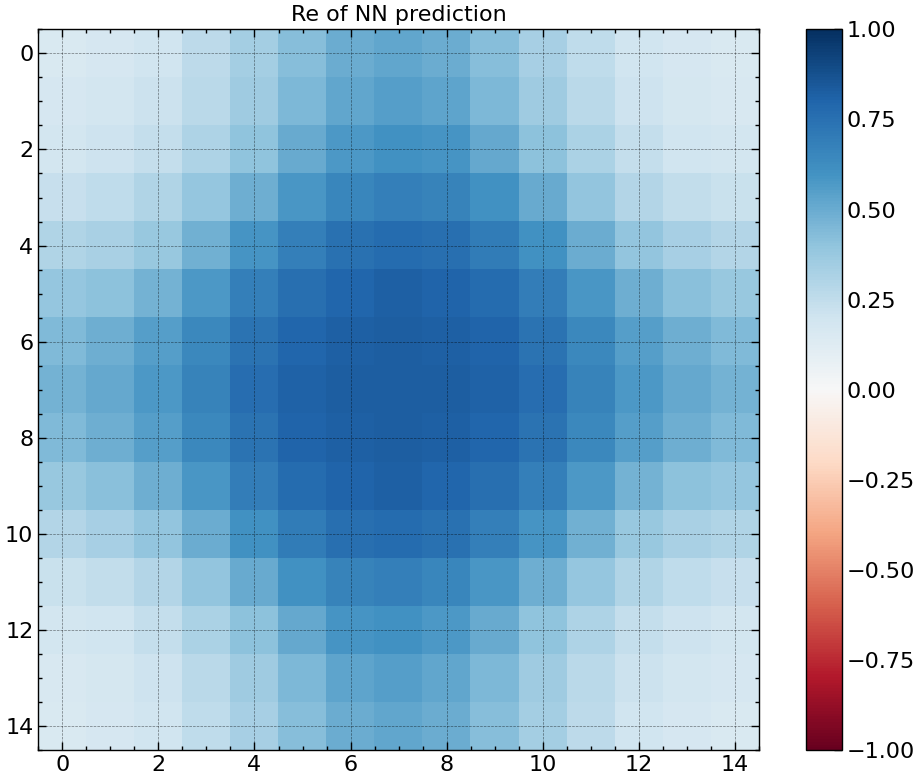

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


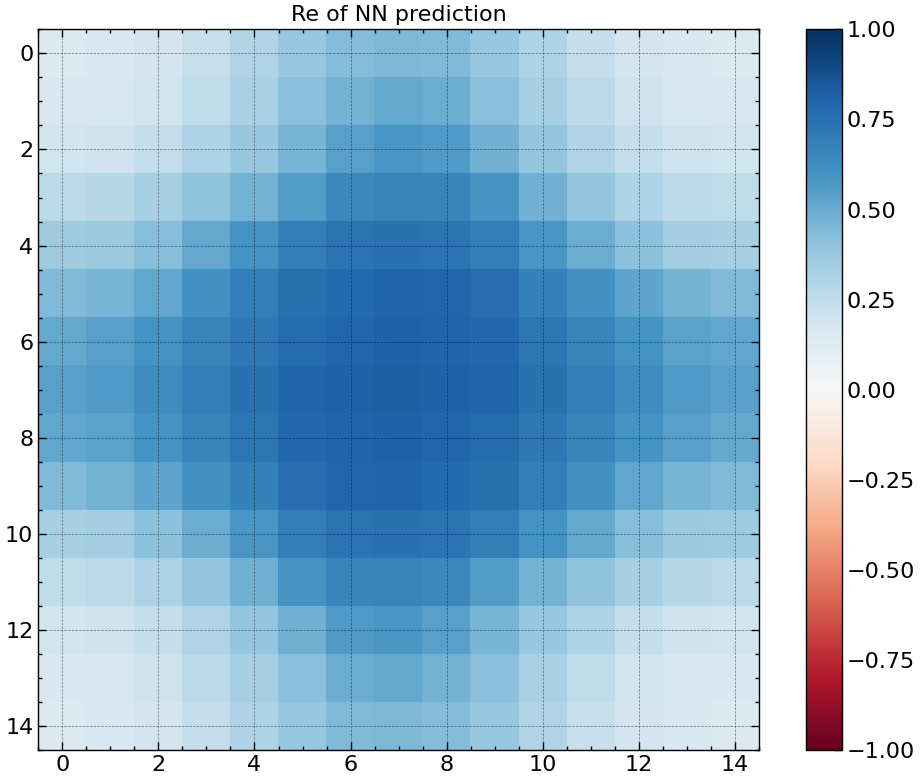

Folded OP_mat shape: (196, 196, 2, 2)
OP_results shape: (2, 392, 392)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


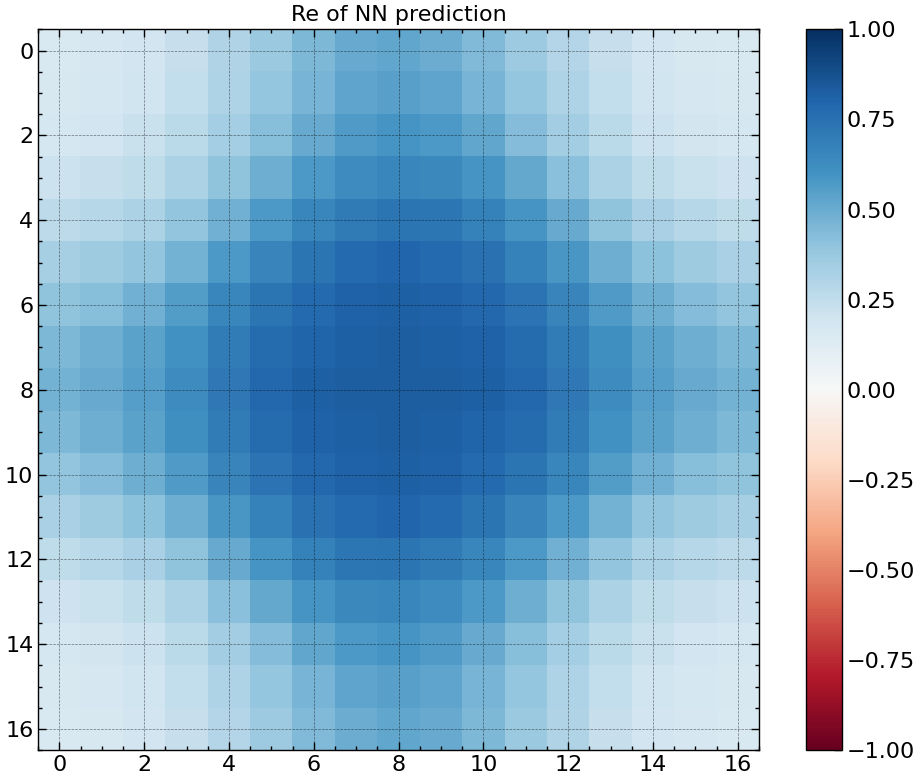

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


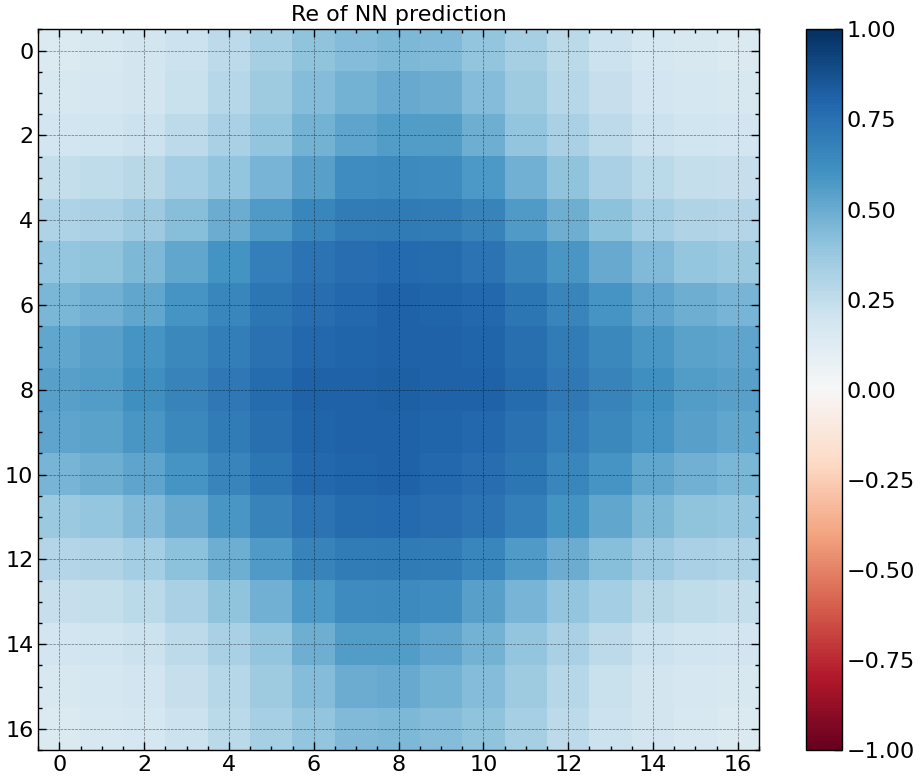

Folded OP_mat shape: (256, 256, 2, 2)
OP_results shape: (2, 512, 512)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


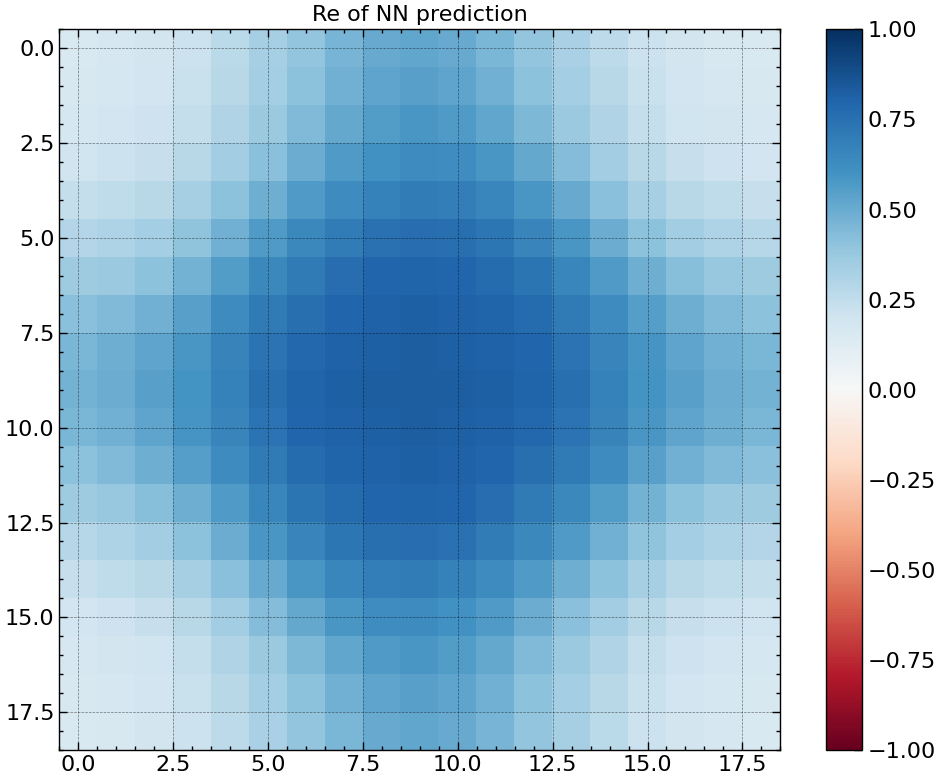

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


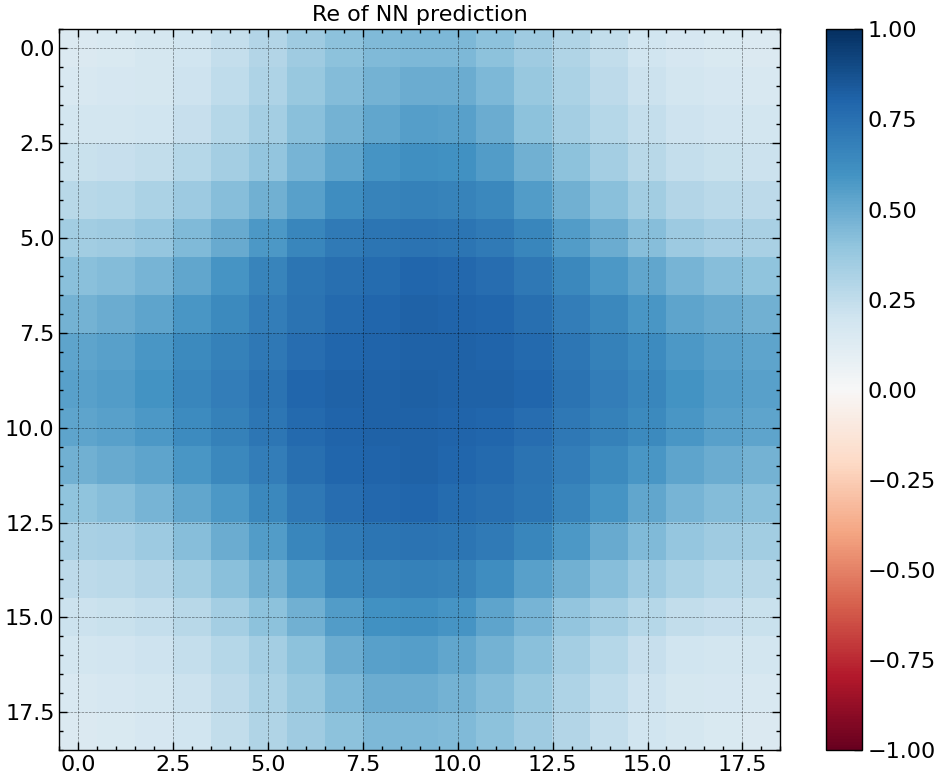

Folded OP_mat shape: (324, 324, 2, 2)
OP_results shape: (2, 648, 648)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


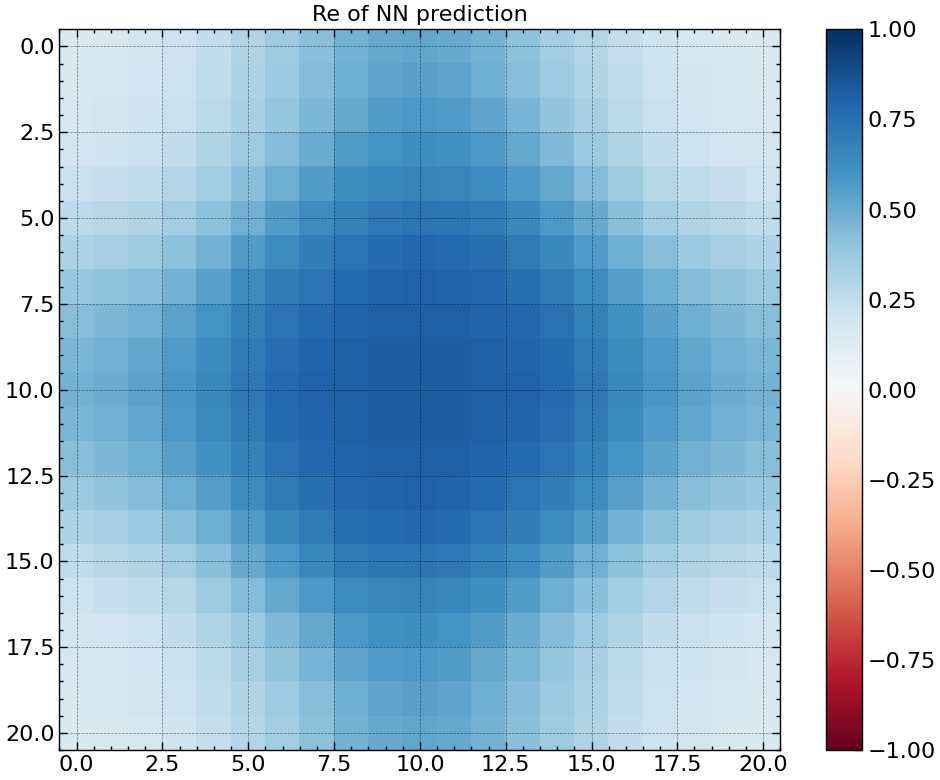

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


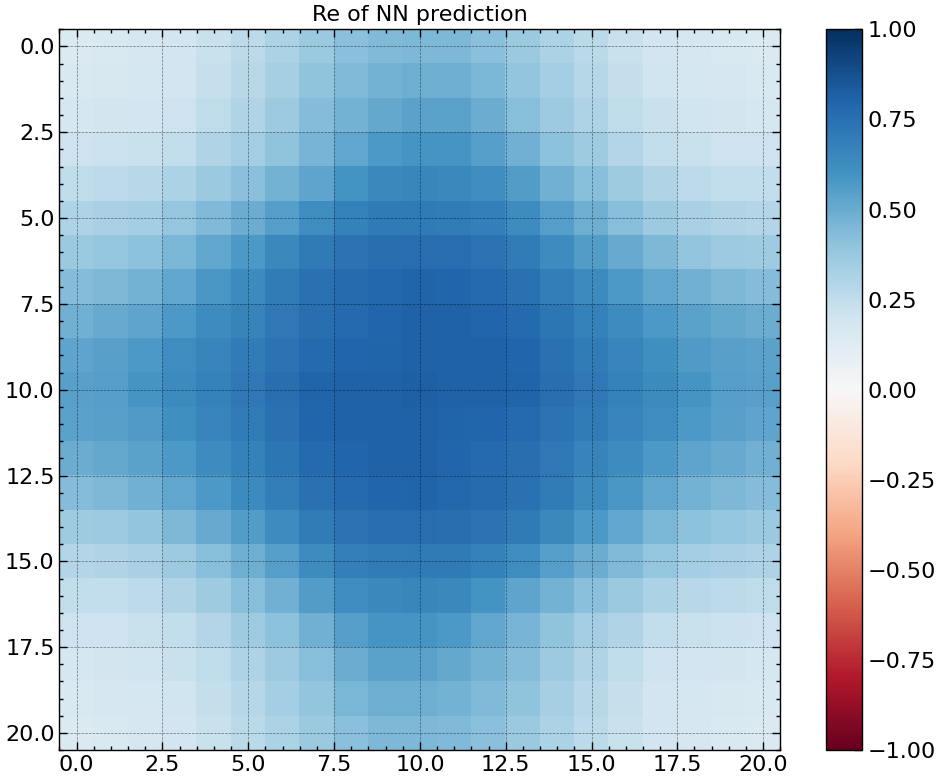

Folded OP_mat shape: (400, 400, 2, 2)
OP_results shape: (2, 800, 800)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


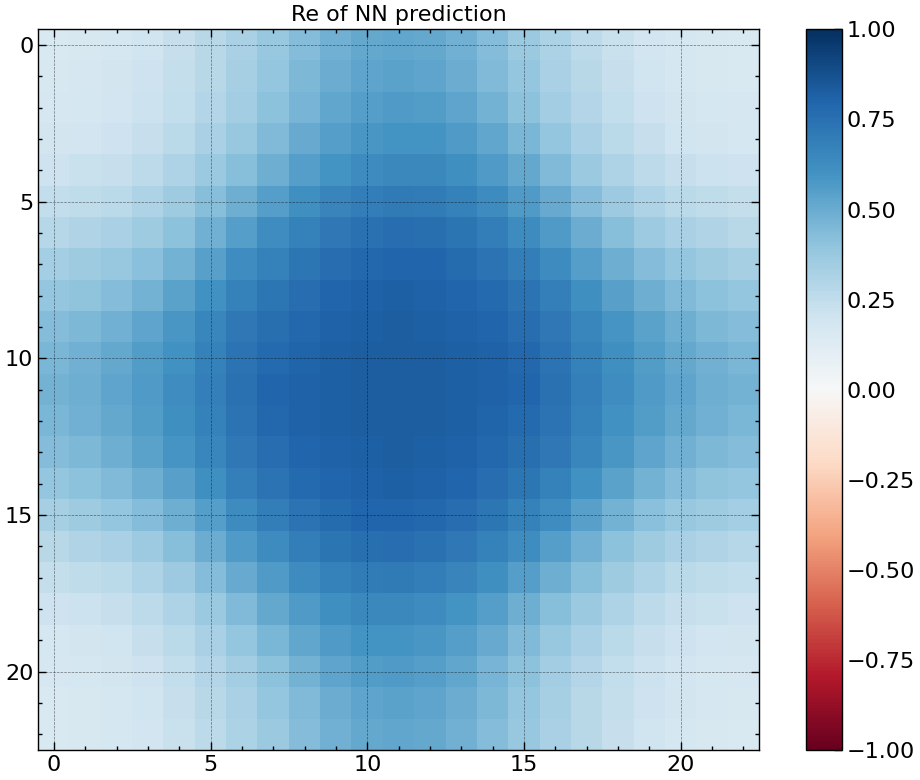

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


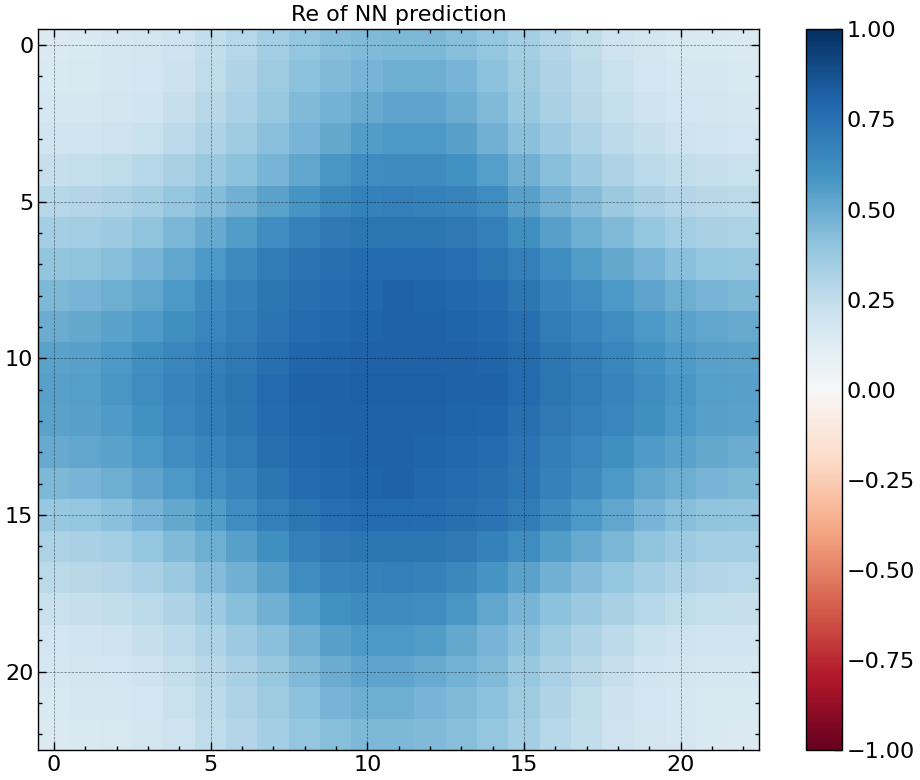

Folded OP_mat shape: (484, 484, 2, 2)
OP_results shape: (2, 968, 968)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


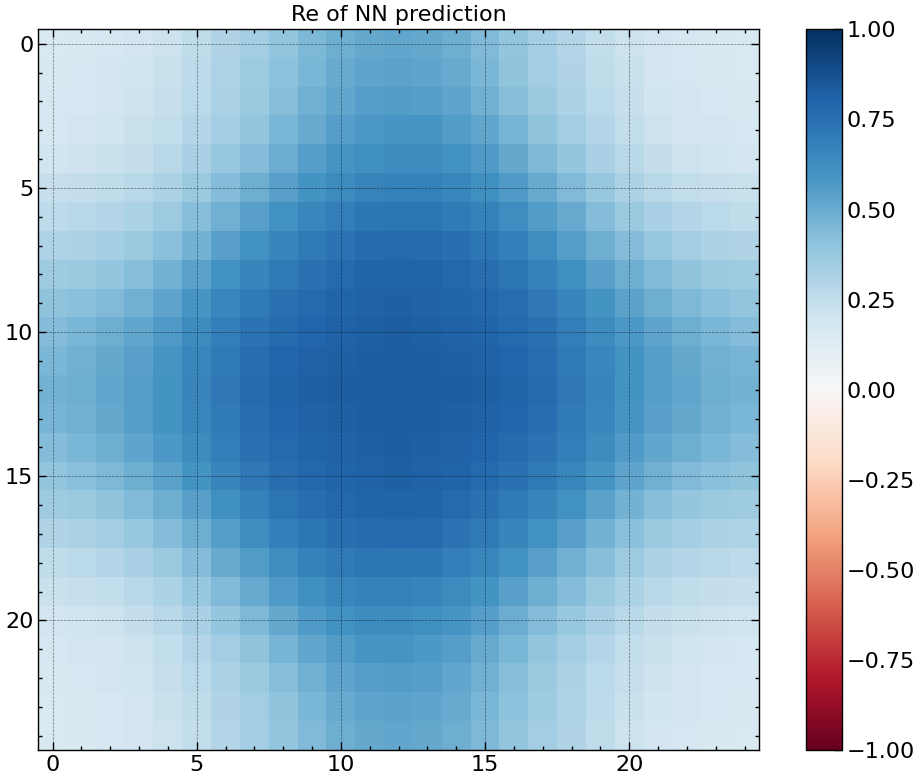

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


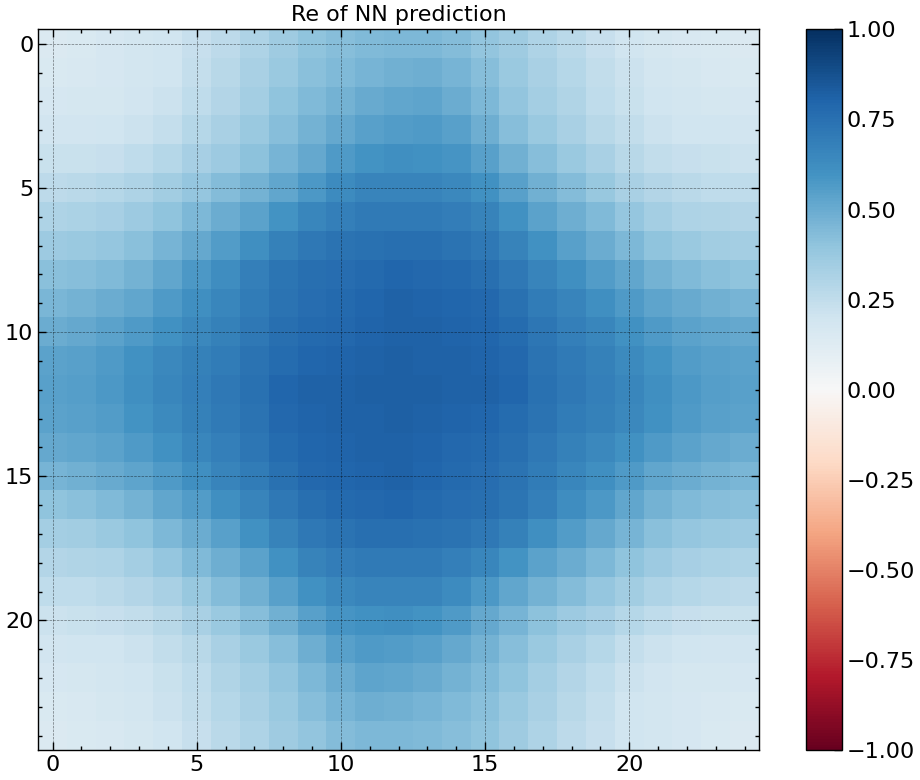

Folded OP_mat shape: (576, 576, 2, 2)
OP_results shape: (2, 1152, 1152)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


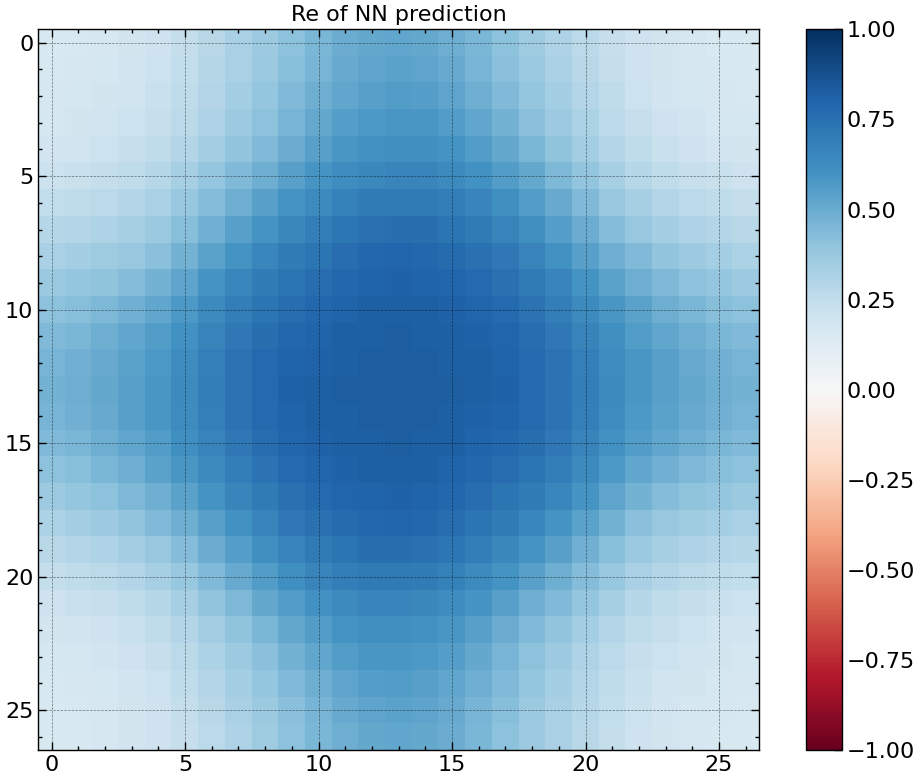

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


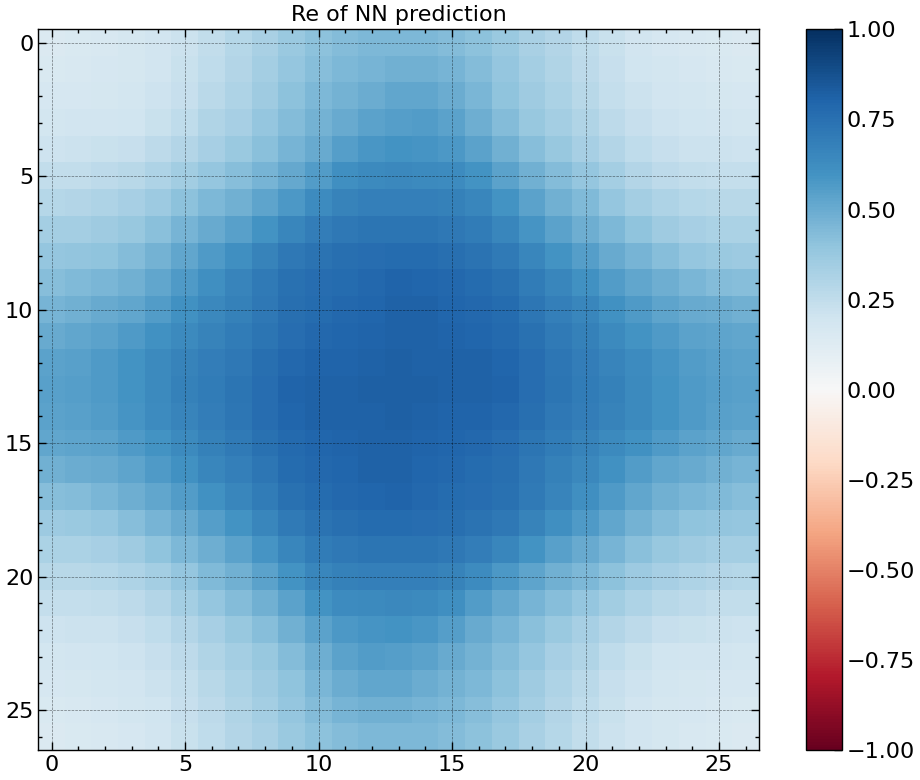

Folded OP_mat shape: (676, 676, 2, 2)
OP_results shape: (2, 1352, 1352)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


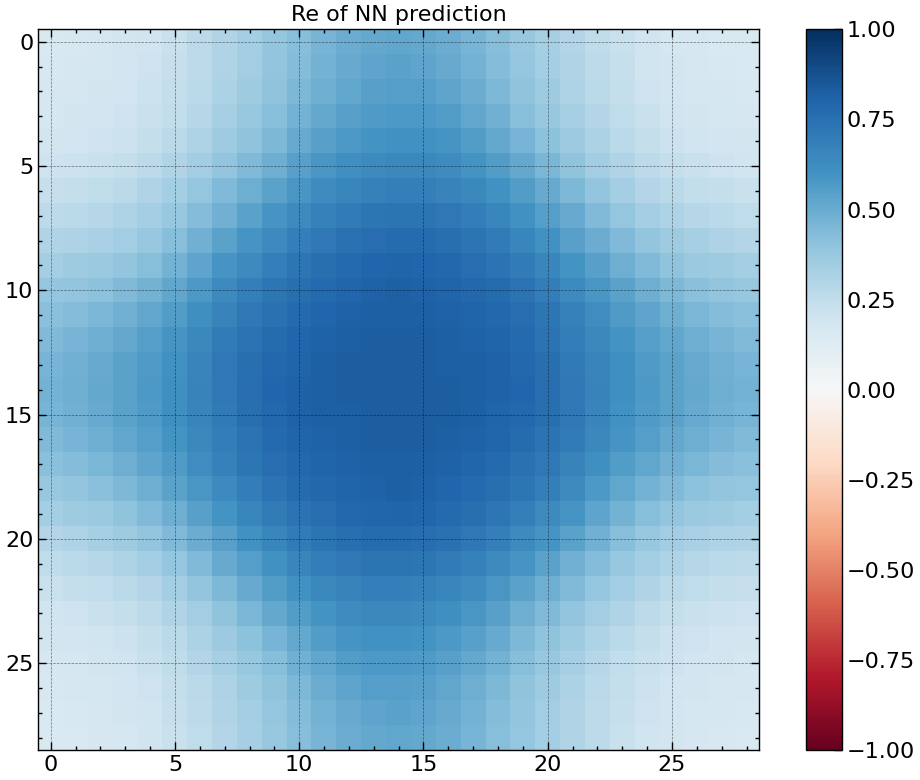

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


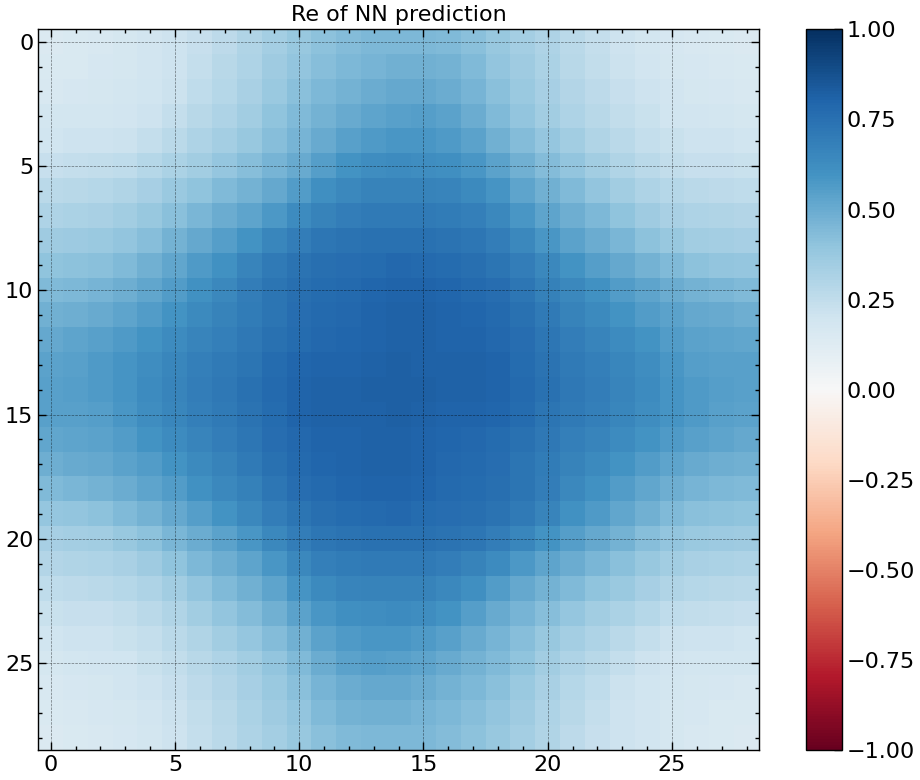

Folded OP_mat shape: (784, 784, 2, 2)
OP_results shape: (2, 1568, 1568)
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


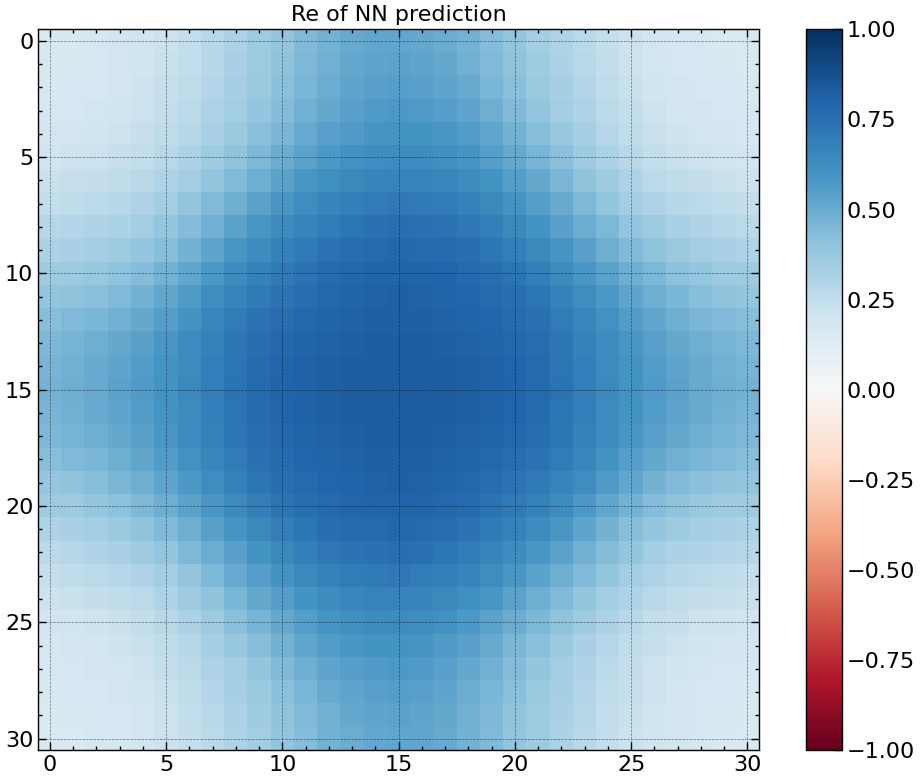

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


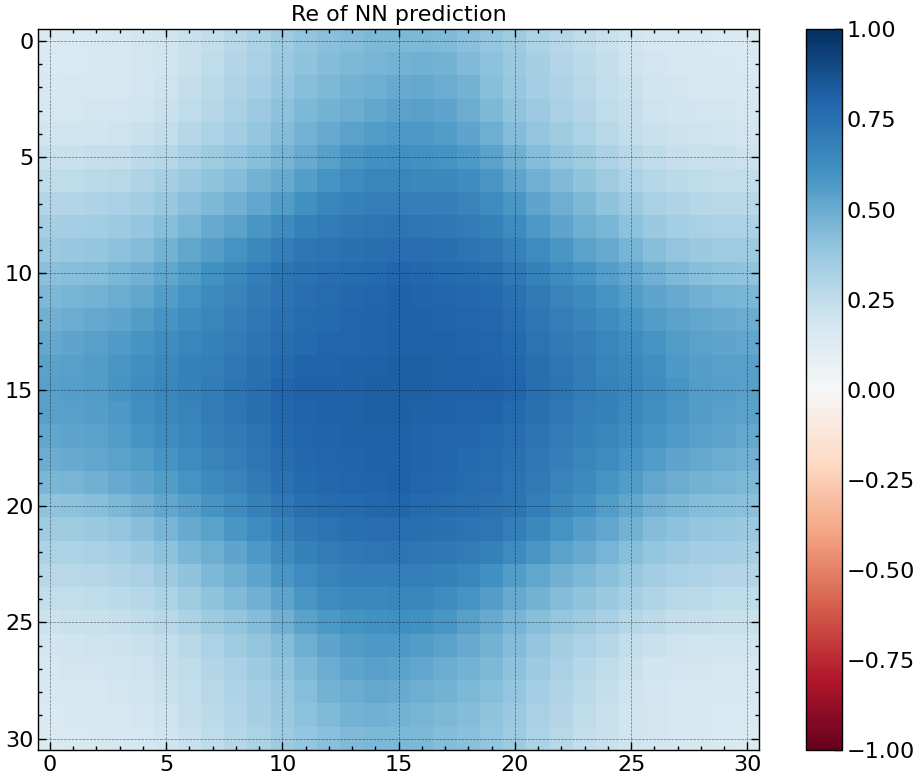

Folded OP_mat shape: (900, 900, 2, 2)
OP_results shape: (2, 1800, 1800)


In [12]:
# generate all the ML output files at once
for L in range(10, 31, 2):
    make_HF_ML(L)

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


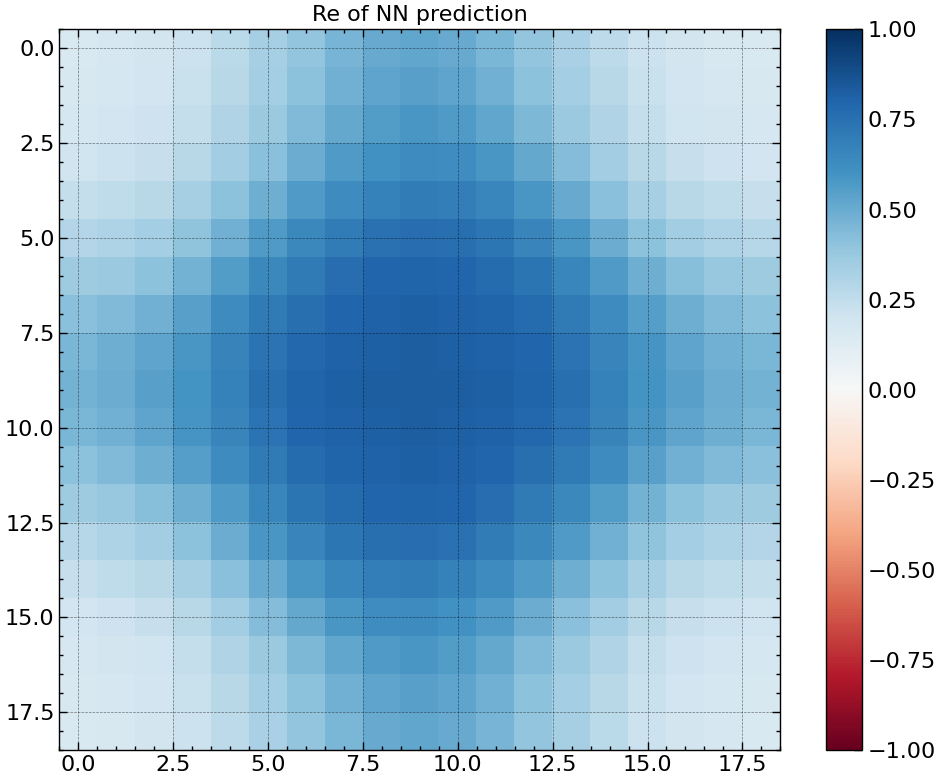

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No
Selected mode: opposite
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : No
  reflection_anti_diag     : No


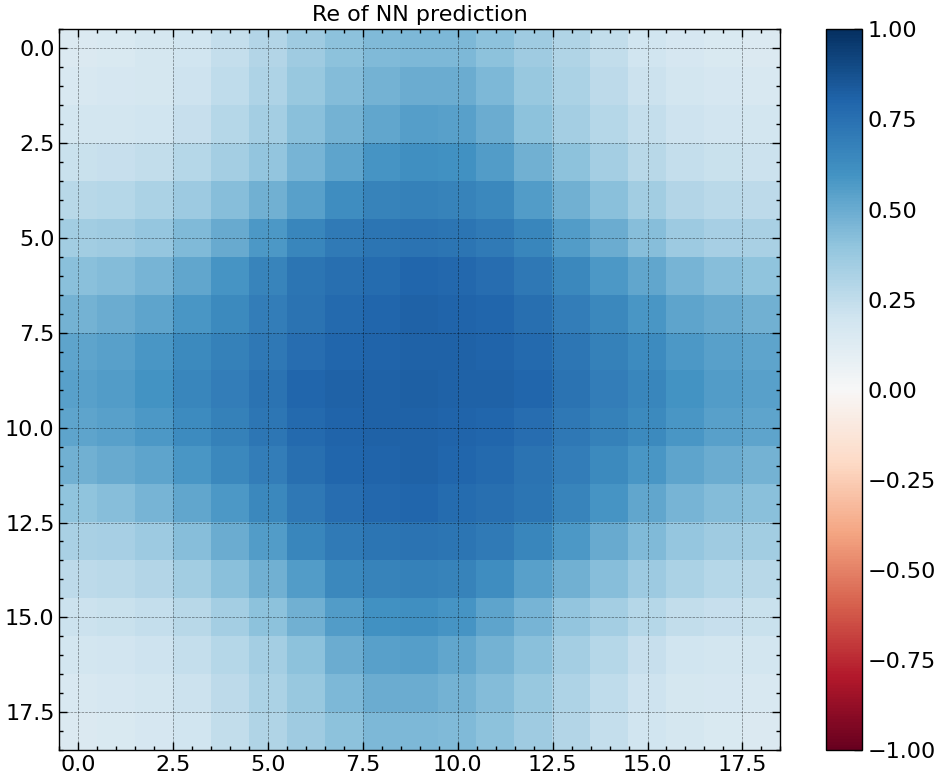

(324, 324, 2, 2)
Max diff: 0.09966787718729878
MSE: 0.00032314420207502277


(np.float64(0.09966787718729878), np.float64(0.00032314420207502277))

In [13]:
# just for testing purposes
diag_list = []
for diag_idx in (0, 1):
    diag_tensor = np.zeros((18, 18, 2, 2))
    for alpha in (0, 1):
        try:
            diag_tensor[:, :, alpha, alpha] = get_model_output(18, diag_idx, alpha, alpha)
        except:
            continue
    diag_list.append(diag_tensor)
folded_OP_mat = reformat_matrix_from_diagonals(diag_list)
print(folded_OP_mat.shape)

# now find the error
test_OP = unfold_OP_mat(folded_OP_mat)
print_comparison(OP_18x18, test_OP)

In [14]:
# test to make sure everything was loaded correctly
with h5py.File(
    f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/SIREN_{label}/SIREN_18x18_{label}.h5", "r"
) as f:
    check_18x18 = np.transpose(f["ML_1"][()])
    check_18x18 = check_18x18[:, :, 0] + (1j * check_18x18[:, :, 1])

print(check_18x18.shape)
print(check_18x18.dtype)

(648, 648)
complex128


In [15]:
print_comparison(OP_18x18, check_18x18)

Max diff: 0.09966787718729878
MSE: 0.00032314420207502277


(np.float64(0.09966787718729878), np.float64(0.00032314420207502277))

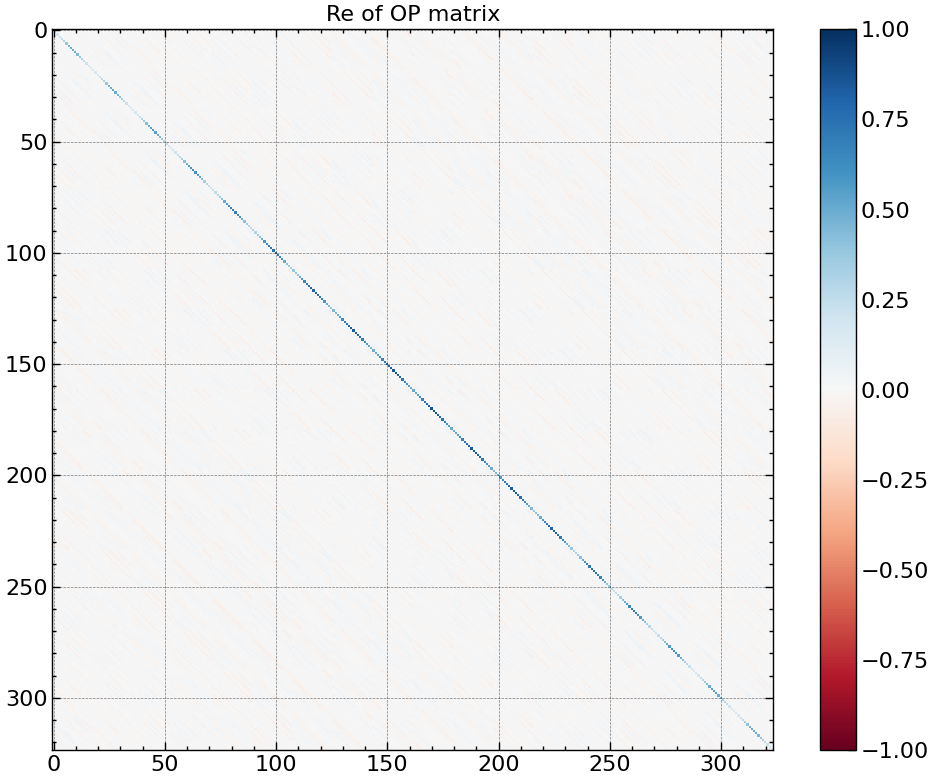

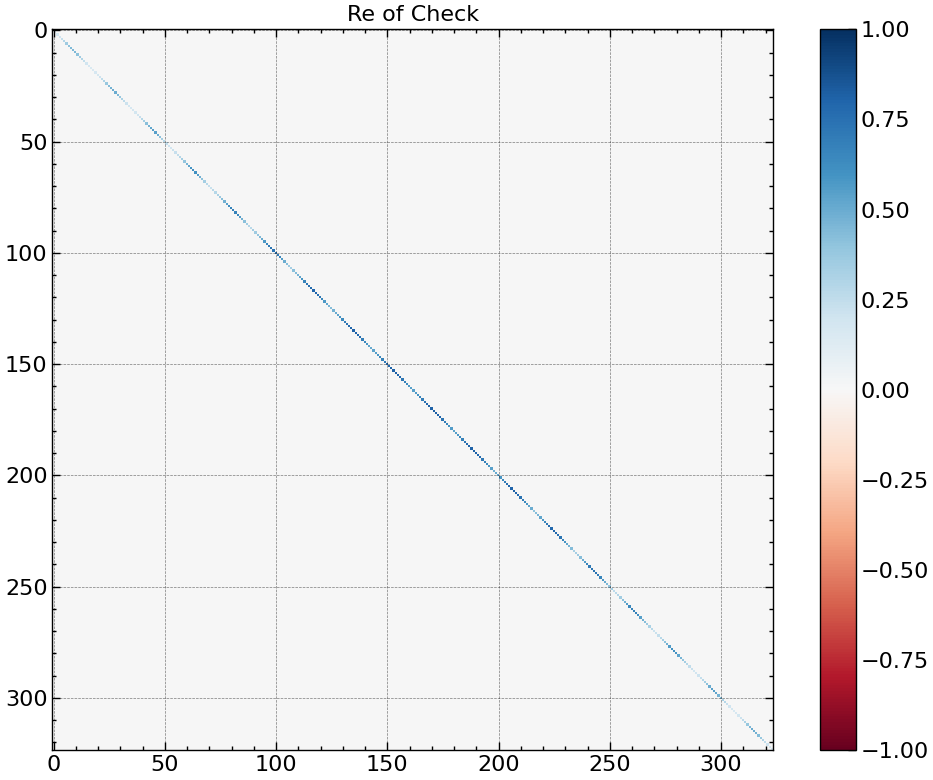

In [16]:
plot_complex_matrix(fold_OP_mat(OP_18x18)[:, :, 1, 1])
plot_complex_matrix(fold_OP_mat(check_18x18)[:, :, 1, 1], title="Check")